In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Activation

# from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [15]:
data = pd.read_csv('samsung_data.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


In [22]:
max_data = [data.max()]
print(max_data)

[Date         2018-10-29
Open              57500
High              57520
Low               56760
Close             57220
Adj Close       52608.7
Volume         64681300
dtype: object]


In [34]:
dataset = []
for i in range(data.shape[0]):
    scale = (data.iloc[i][[1, 2, 3, 4, 6]] / max_data[0][[1, 2, 3, 4, 6]])
    dataset.append(scale)    #0~1


In [36]:
dataset[1:5]

[Open      0.521043
 High      0.522253
 Low       0.516209
 Close     0.512059
 Volume    0.195529
 dtype: object,
 Open      0.518261
 High      0.521558
 Low       0.517266
 Close     0.524292
 Volume    0.175595
 dtype: object,
 Open      0.518957
 High      0.522253
 Low       0.524665
 Close     0.523943
 Volume     0.16833
 dtype: object,
 Open      0.522435
 High      0.522253
 Low       0.518675
 Close     0.519049
 Volume    0.123827
 dtype: object]

In [127]:
look_back = 20    #20
sequence_length = look_back + 1

result = []

#dataset len is 1225
for index in range(len(dataset) - sequence_length):    #0~1204
    result.append(dataset[index: index + sequence_length])    #21개씩 묶음

len(result)   #총 1204개의 자료

1204

In [128]:
result = np.array(result, dtype=float)    #convert list to numpy

#print(result.shape)

row = int(round(result.shape[0] * 0.9))   #0.9정도 학습 데이터로 사용 -> 1084, 0.1은 테스트 데이터로 사용

train = result[:row, :, :]    #result의 0~1084,전체,전체  (train data 0~1084까지 분리)

np.random.shuffle(train)    #train을 섞어줌 (오버핏 방지)

x_train = train[:, :-1, :]    #(배치수,행,열)(21번 째 자료는 정답으로 쓸 것이므로 21번 째 행을 제외하고 x_train에 넣음)
# # x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1, 3]    #정답은 21번째 행의 Date Open High Low Close Adj_Close Vol 중 Low로 이용

x_test = result[row:, :-1, :]    #테스트 데이터에 쓸 x_test (입력값)
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1, 3]    #테스트 데이터의 답


train.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape    #미래에 까먹을 나를 위해 말하면 y리스트 값은 1차원

((1084, 21, 5), (1084, 20, 5), (120, 20, 5), (1084,), (120,))

In [141]:
model = Sequential()    #층 쌓기 전 쓰는 코드(솔직히 의미는 잘 모름)

model.add(LSTM(50, return_sequences=True, input_shape=(20, 5)))    #input_shape오 입력 데이터 모양 설계 (첫 번째 층)  (20,5)

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))    #affine

model.compile(loss='mse', optimizer='rmsprop')    #adam을 사용하면 변화를 즉각 반영하기 힘듬 따라서 rmsprop
#손실함수는 평균제곱오차 사용, optimizer은 Momentum, AdaGrad, RMSProp, Adam 중 RMSProp사용

model.summary()    #층 요약해서 보여줌

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 20, 50)            11200     
_________________________________________________________________
lstm_35 (LSTM)               (None, 64)                29440     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 40,705
Trainable params: 40,705
Non-trainable params: 0
_________________________________________________________________


In [150]:
hist = model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=20,    #10 batch   20,100이 좋을듯
    epochs=100)    #12 epochs

Epoch 1/100
55/55 [==============================] - 1s 18ms/step - loss: 1.8294e-04 - val_loss: 4.5582e-04
Epoch 2/100
55/55 [==============================] - 1s 17ms/step - loss: 1.5777e-04 - val_loss: 1.8048e-04
Epoch 3/100
55/55 [==============================] - 1s 16ms/step - loss: 1.6600e-04 - val_loss: 1.8517e-04
Epoch 4/100
55/55 [==============================] - 1s 18ms/step - loss: 1.5829e-04 - val_loss: 2.2012e-04
Epoch 5/100
55/55 [==============================] - 1s 16ms/step - loss: 1.5460e-04 - val_loss: 2.8801e-04
Epoch 6/100
55/55 [==============================] - 1s 15ms/step - loss: 1.7418e-04 - val_loss: 3.3736e-04
Epoch 7/100
55/55 [==============================] - 1s 15ms/step - loss: 1.5372e-04 - val_loss: 5.8104e-04
Epoch 8/100
55/55 [==============================] - 1s 15ms/step - loss: 1.6216e-04 - val_loss: 8.8670e-04
Epoch 9/100
55/55 [==============================] - 1s 15ms/step - loss: 1.5602e-04 - val_loss: 2.3087e-04
Epoch 10/100
55/55 [========

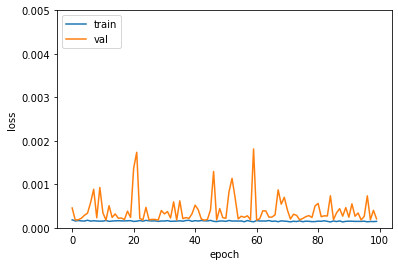

In [164]:
# 손실함수
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 0.005)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

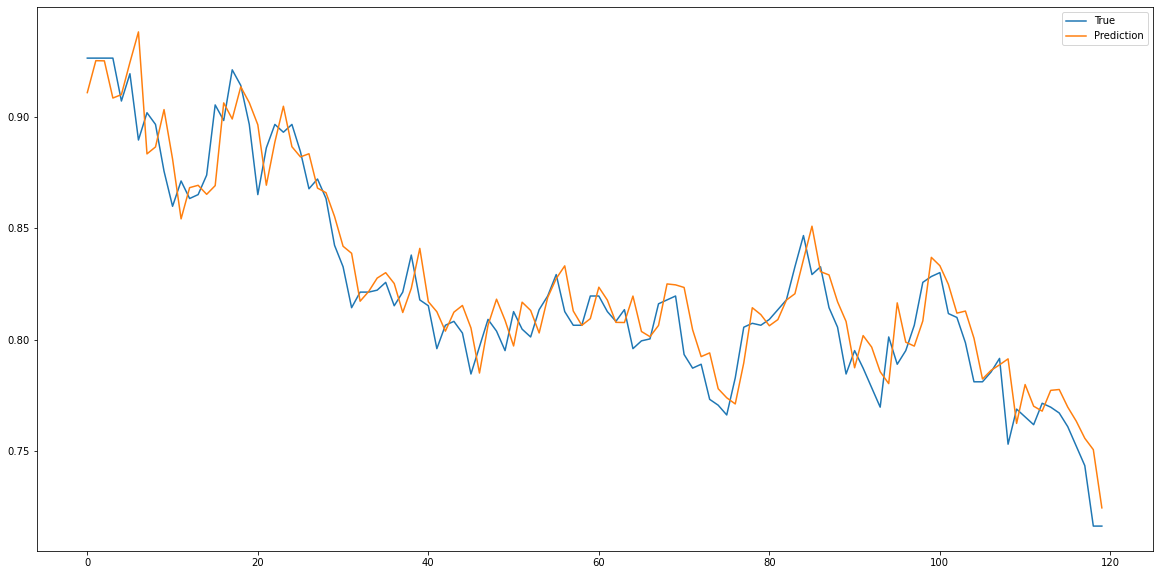

In [175]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [185]:
#use ai
xhat = x_test[0]
prediction = model.predict(np.array([xhat]), batch_size=1)
result = prediction * max_data[0][1]
print(result)

[[52370.312]]
